In [50]:
import numpy as np
import pandas as pd
from matplotlib import cm
from matplotlib import pyplot as plt
import scipy.optimize as opt
import scipy.linalg as la
import scipy.integrate as sciint
from itertools import product
from functools import partial

import os

# Mine
from wilson_cowan_2d.simulations import concrete_wc_kernel as wck
from wilson_cowan_2d.simulations import wc_params as wcp
from wilson_cowan_2d.simulations.nonlinear_functions import decreasing_exponential
from wilson_cowan_2d.analysis import nulclines as nuc
from wilson_cowan_2d.analysis import stability as sta

# Jupyter Specific
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython.display import clear_output

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Fixed Point Analysis

In [11]:
τe = 1
τi = 0.5 * τe
σe = 1
σi = 2 * σe
ω = 0.8

u_bar, v_bar = np.array([0.424, 0.204])
param = wcp.DefaultParams(τ = np.array([τe, τi]), η = 0.1, size = 2**8, σ = np.array([σe, σi])

rang = np.linspace(0,100, 10_000)
dw_test = sta.calc_Dω_range(param, (u_bar, v_bar), 1, (2,3,5), rang)

_ = [plt.plot(rang, dw) for dw in dw_test]
# _ = plt.legend()
_ = plt.xlim(0.3, 2)
_ = plt.ylim(-5, 10)
_ = plt.hlines(0,0,1_000, color='r', linestyle=":")

### Periodic Oribit Analysis

In [33]:
ωs = np.linspace(0, 1, 10)
σs = τs = np.linspace(0.5,1,21)

In [94]:
output = list()
ωs = np.arange(0.1, 2.5, 0.01)
σs = τs = np.arange(0.1, 2.5, 0.01)  # np.linspace(0.5,2.5,21)

τ = 0.3
τe = 1
τi = τ * τe


param = wcp.DefaultParams(τ = np.array([τe, τi]).reshape(2,1), η = 1, size = 1)
# param.Θ = np.array([0.08, 0.4])

inp = np.array([0.4, 0.2]).reshape(2,1)

test = wck.WCUnif(inp, param)
end = 10
ures = test((0, end), t_eval=np.arange(0, end, 0.1)) 
uv_init = ures._solved.y.T[-1].reshape(2,1)

# Find Period
def find_period_func(T):
    start = wck.WCUnif(uv_init, param)
    res = start((0,T),simple=True, t_eval=(0,T))
    return np.sum(np.abs(uv_init - res.y.T[-1].reshape(2,1)))  # , res

period = opt.fsolve(find_period_func, 0.3)[0]

period

test = wck.WCUnif(uv_init, param)
new_res = test((0,period), simple=True)

new_u, new_v = new_res.y
_=  plt.plot(new_u, new_v)

ValueError: too many values to unpack (expected 4)

In [90]:
for ix, (ω, σ) in enumerate(product(ωs, σs)):
    σe = 1
    σi = σ * σe
    param = wcp.MondronomyParams\
    .default(τ = np.array([τe, τi]), η = 1, size = 1, σ=np.array([σe, σi]), ω=ω)
    
    # Find Mondronomy Matrix
    def update(t, inp):
        X  = inp[0:4].reshape(2,2)
        u, v = inp[4:]
        A, (θe, θi), (τe, τi), η, (σe, σi), ω = param.derivative_tuple
        F = param.F
        AA = sta.calc_AA(u, v, param)

        dX = (AA @ X).ravel()
        du = F(A[0,0]*u - A[0,1]*v - θe) - u
        dv = (F(A[1,0]*u - A[1,1]*v - θi) - v)/τi

        return _make_inp(dX, np.array([du, dv]))

    def _make_inp(X, uv):
        return np.concatenate((X.ravel(), uv.ravel()))

    inp = _make_inp(np.eye(2).ravel(), uv_init)  # Inital Condition
    new_res = sciint.solve_ivp(update, (0, period), inp)

    # Calc Q
    X = new_res.y[:4].T[-1].reshape(2,2)
    Q = 1 + np.trace(X) + la.det(X)
    
    if ix % 222-1 == 1:
        clear_output(wait=True)
        print(f"On iter: {ix: >6}, params <- σ:{σ:>0.2}, τ:{τ:>0.2}, ω:{ω:>0.2}, Q:{Q:>0.2}") 

    output.append({"σ":σ, "τ":τ, "ω":ω, "Q":Q})

On iter:  57500, params <- σ:1.5, τ:0.27, ω:2.5, Q:2.6


In [91]:
out = pd.DataFrame(output)
# output_saves[τ] = out
out.loc[lambda x: x.Q < 0].min(axis=0)

σ    1.400000
τ    0.270000
ω    0.640000
Q   -0.010723
dtype: float64

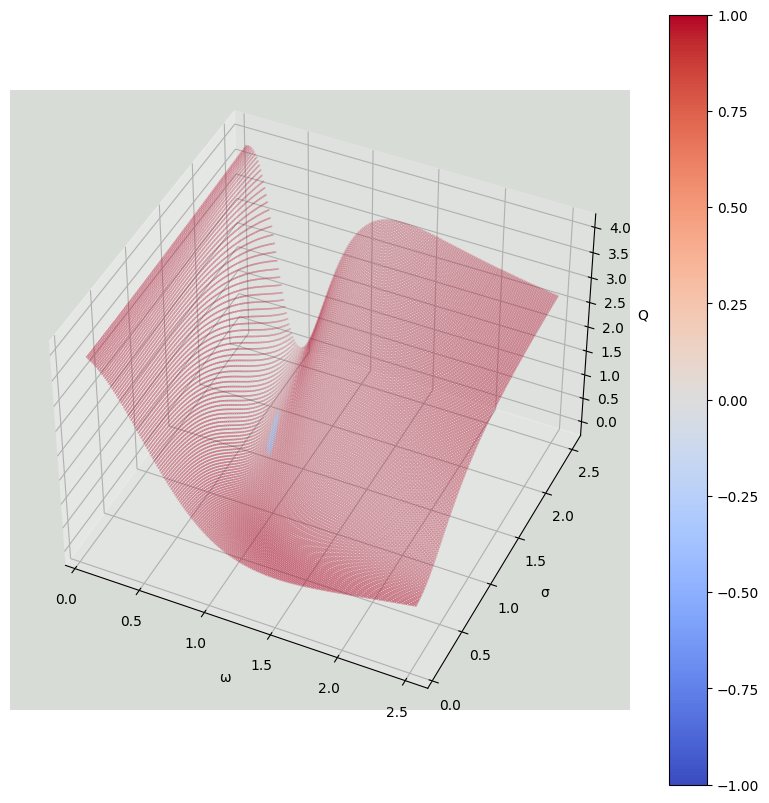

In [92]:
fig_name = f"linear_stability_tau-{τ}.png"
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')

im = ax.scatter(out.ω, out.σ, np.sign(out.Q)*(np.abs(out.Q)), c=np.sign(out.Q)
                , s=0.02, cmap=cm.coolwarm)
_ = ax.set_ylabel('σ')
_ = ax.set_xlabel('ω')
_ = ax.set_zlabel('Q')

ax.set_facecolor('xkcd:light gray')
ax.view_init(42, -65)

_ = plt.colorbar(im)

# plt.savefig(os.path.join(img_path, fig_name), bbox_inches='tight')

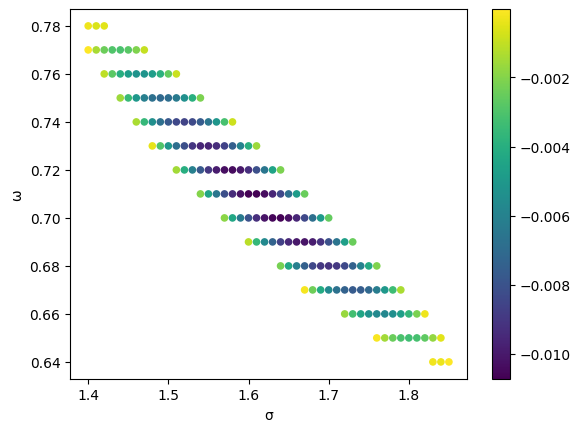

In [93]:
fig_name = f"linear_stability_negitive_projection_tau-{τ}.png"
dat = out.loc[lambda x: x.Q <0][['ω', 'σ', 'Q']]
_ = plt.scatter(dat.σ, dat.ω, s=20, cmap=cm.viridis, c=dat.Q)
_ = plt.xlabel("σ")
_ = plt.ylabel("ω")
_ = plt.colorbar()

# plt.facecolor('xkcd:light gray')

# plt.savefig(os.path.join(img_path, fig_name), bbox_inches='tight')